In [57]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import numpy as np
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(4 * 64, 100)
        self.fc2 = nn.Linear(100, 22)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 4 * 64)))
        x = self.fc2(x)
        return x

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.fc1 = nn.Linear(4 * 64, 180)
        self.fc2 = nn.Linear(180, 22)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, 4 * 64)))
        x = self.fc2(x)
        return x

class Net_NumbersFirst(nn.Module):
    def __init__(self,proba,kconv1, kconv2, kconv3, kernel1, kernel2, kernel3):
        super(Net_NumbersFirst, self).__init__()
        self.conv1 = nn.Conv2d(2, kconv1, kernel_size=kernel1)
        
        self.conv2 = nn.Conv2d(kconv1, kconv2, kernel_size=kernel2)
        self.conv2_bn = nn.BatchNorm2d(kconv2)
        
        self.conv3 = nn.Conv2d(kconv2, kconv3, kernel_size=kernel3)
        self.conv3_bn = nn.BatchNorm2d(kconv3)
        self.drop1 = nn.Dropout(p=proba)
        
        after1 = (14-kernel1+1)/2
        after2 = after1-kernel2+1
        after3 = after2-kernel3+1
        
        self.fc1 = nn.Linear( int(after3*after3*kconv3) , 180)
        self.fc1_bn = nn.BatchNorm1d(180)
        self.fc2 = nn.Linear(180, 20)

        self.fc3 = nn.Linear(20, 100)
        self.fc3_bn = nn.BatchNorm1d(100)
        self.fc4 = nn.Linear(100, 2)

    def forward(self, x, kernel1, kernel2, kernel3):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        
        x = F.relu(self.conv3_bn(self.conv3(x)))

        x = self.drop1(x)

        after1 = (14 - kernel1 + 1)/2
        after2 = after1 - kernel2 + 1
        after3 = after2 - kernel3 + 1
        x = F.relu(self.fc1_bn(self.fc1(x.view(-1, int(after3*after3*kconv3)))))
        x = self.fc2(x)
        numbers = x
        
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        comparison = x

        output_list = [comparison, numbers]
        output = torch.cat(output_list, dim=1)

        return output


In [59]:
def compute_nb_errors(model, input, target_classes, target_labels, mini_batch_size,
                                                    kernel1, kernel2, kernel3):
    errors_num0 = 0
    errors_num1 = 0
    errors_comparison = 0

    # we have too much data to give everything and giving one by one is too slow
    # so we give by minibatch
    for b in range(0, input.size(0), mini_batch_size):

        input_model = input[b: b + mini_batch_size]
        output = model(input_model, kernel1, kernel2, kernel3)
        #print(output.size())

        winner_output0 = torch.argmax(output[:, 2:12], dim=1)
        winner_output1 = torch.argmax(output[:, 12:22], dim=1)
        winner_comparison = torch.argmax(output[:, 0:2], dim=1)

        target_classes_vect0 = prologue.convert_to_one_hot_labels(torch.zeros(10), target_classes[b: b + mini_batch_size, 0])
        target_classes_vect1 = prologue.convert_to_one_hot_labels(torch.zeros(10), target_classes[b: b + mini_batch_size, 1])

        winner_target0=torch.argmax(target_classes_vect0, dim=1)
        winner_target1=torch.argmax(target_classes_vect1, dim=1)
        winner_target_comparison = target_labels[b: b + mini_batch_size]

        #print('Winner 0')
        #print(winner_output0.size())
        #print(winner_target0.size())
        #print(target_classes_vect0.size())
        #print('Winner 1')
        #print(winner_output1.size())
        #print(winner_target1.size())
        #print('Comparison winner')
        #print(winner_comparison.size())
        #print(winner_target_comparison.size())


        # we want the largest index to be the same in both
        error_num0 = winner_output0 - winner_target0
        error_num1 = winner_output1 - winner_target1
        error_comparison = winner_comparison -winner_target_comparison

        correct0 = error_num0[error_num0 == 0]
        correct1 = error_num1[error_num1 == 0]
        correct_comparison = error_comparison[error_comparison == 0]

        num_samples = output.size()
        num_correct0 = correct0.size()
        num_correct1 = correct1.size()
        num_correct_comparison = correct_comparison.size()

        nb_errors0 = num_samples[0] - num_correct0[0]
        nb_errors1 = num_samples[0] - num_correct1[0]
        nb_errors_comparison = num_samples[0] - num_correct_comparison[0]


        # print(nb_errors)
        errors_num0 += nb_errors0
        errors_num1 += nb_errors1
        errors_comparison += nb_errors_comparison


    return errors_num0, errors_num1, errors_comparison


In [60]:
def train_model(model, train_input, train_target, train_labels, nb_epochs, eta, \
                                                        kernel1, kernel2, kernel3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    batch_size = 100


    for e in range(nb_epochs):
        #print(e)
        for b in range(0, train_input.size(0), batch_size):

            input_model = train_input[b: b + batch_size]
            #print('Input size')
            #print(input_model.size())

            #output_model outputs for example: [0,1,3,5]
            output_model = model(input_model, kernel1, kernel2, kernel3)

            #print('Output obtained')
            #print(output_model.size())


            loss_comparison = criterion(output_model[:,0:2], train_labels[b:b + batch_size])
            #print('Loss 1 done')
            loss_number1 = criterion(output_model[:,2:12], train_target[b:b + batch_size][:,0])
            #print('Loss 2 done')
            loss_number2 = criterion(output_model[:,12:22], train_target[b:b + batch_size][:,1])
            #print('Loss 3 done')

            loss = 1/2*loss_comparison + 1/4*loss_number1 + 1/4*loss_number2
            #print(loss)
            optimizer.zero_grad()
            #print('optimizer zero grad done')
            loss.backward()
            #print('loss backward done')
            optimizer.step()
            #print('optimizer step done')

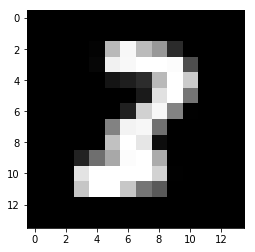

3888
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1


Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Ste

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 25
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.001
Nb epochs: 50
Step size eta: 0.1
Step size eta: 0.01
Step size eta: 0.0

In [61]:
mini_batch_size = 100

#create samples
nb=1000
train_input, train_labels, train_classes, test_input, test_labels, test_classes = prologue.generate_pair_sets(nb)
#print(train_input.size())

#Notes
#loss on classifying the classes
#loss on the integers themselves

#Data Exploration
#print(train_classes)
#print(train_labels)
#1 entry is two images 14x14 matrices
#print(train_input[1][1])
plt.imshow(train_input[0][1], cmap='gray')
plt.show()


probas = [0, 0.25, 0.5]
kconvs1 = [10, 30 , 60 ]
kconvs2 = [10, 30 , 60 ]
kconvs3 = [10, 30 , 60 ]
kernels1 = [3,5]
kernels2 = [2,3]
kernels3 = [2,3]
etas = [0.100, 0.010, 0.001]
nb_epochs = [25, 50]

nb_combos=len(probas)*len(kconvs1)*len(kconvs2)*len(kconvs1)*len(kernels1)*len(kernels1)*len(kernels1)*len(etas)*len(nb_epochs)
print(nb_combos)
#9 Hyperparameters and 6 Accuracies for each combo
hyperparam_tensor=torch.zeros([nb_combos,9+6], dtype=torch.float32)
nb_model=0

for kconv1 in kconvs1:

    for kconv2 in kconvs2:

        for kconv3 in kconvs3:

            for kernel1 in kernels1:

                for kernel2 in kernels2:

                    for kernel3 in kernels3:

                        for proba in probas:

                            for nb_epoch in nb_epochs:
                                print('Nb epochs: {}'.format(nb_epoch))

                                for eta in etas:
                                    print('Step size eta: {}'.format(eta))
                                    
                                    #Create model
                                    model1 = Net()
                                    model2 = Net2()
                                    model3 = Net_NumbersFirst(proba, kconv1, kconv2, kconv3, kernel1, kernel2, kernel3)
                                    #models = [model1, model2, model3]
                                    models = np.array([model3])
                                        
                                    for model in models:
                                        #print(nb_model)
                                        #print(model)
                                        #Train model
                                        train_model(model, train_input, train_classes, train_labels, nb_epoch, \
                                                    eta, kernel1, kernel2, kernel3)

                                        #Calculate Train and Test error percentages
                                        errors_num0_train, errors_num1_train, errors_comparison_train = \
                                                compute_nb_errors(model, train_input, train_classes, \
                                                                  train_labels, mini_batch_size, \
                                                                  kernel1, kernel2, kernel3)

                                        errors_num0_test, errors_num1_test, errors_comparison_test = \
                                                compute_nb_errors(model, test_input, test_classes, \
                                                                  test_labels,mini_batch_size, \
                                                                  kernel1, kernel2, kernel3)

                                        #print('Comparison Test error: {} %, First number Test error: {} %, Second number Test error: {} % '\
                                                #.format(errors_comparison_test*100/1000,errors_num0_test*100/1000,errors_num1_test*100/1000))
                                        #print('Comparison Train error: {} %, First number Train error: {} %, Second number Train error: {} %' \
                                                  #.format(errors_comparison_train*100/1000, errors_num0_train*100/1000, errors_num1_train*100/1000))
                                        
                            
                                        hyperparam_tensor[nb_model,:]=torch.Tensor([kconv1, kconv2, kconv3,\
                                                                                   kernel1, kernel2, kernel3,\
                                                                                   proba, nb_epoch, eta, \
                                                                                   errors_comparison_test*100/1000,errors_num0_test*100/1000,errors_num1_test*100/1000,\
                                                                                   errors_comparison_train*100/1000, errors_num0_train*100/1000, errors_num1_train*100/1000])
                                        nb_model += 1
print('Done')

In [62]:
hyperparam_tensor[4]

tensor([1.0000e+01, 1.0000e+01, 1.0000e+01, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 5.0000e+01, 1.0000e-02, 1.7400e+01, 1.9600e+01, 2.0200e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00])

In [63]:
value, index = torch.min(hyperparam_tensor[:,9],0)

In [64]:
value

tensor(11.2000)

In [65]:
index

tensor(2883)

In [66]:
hyperparam_tensor[index,:]

tensor([60.0000, 10.0000, 60.0000,  3.0000,  2.0000,  2.0000,  0.0000, 50.0000,
         0.1000, 11.2000, 17.1000, 17.9000,  0.0000,  0.8000,  0.5000])

In [43]:
100-13.9

86.1